In [68]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms, utils

In [69]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor()
])

# train_set = datasets.ImageFolder(
#     root='../archive/fruits-360-original-size/fruits-360-original-size/Training',
#     transform=transform
# )

# validation_set = datasets.ImageFolder(
#     root='../archive/fruits-360-original-size/fruits-360-original-size/Validation',
#     transform=transform
# )

# test_set = datasets.ImageFolder(
#     root='../archive/fruits-360-original-size/fruits-360-original-size/Test',
#     transform=transform
# )

## Check

train_set = datasets.ImageFolder(
    root='../archive/fruits-360_dataset/fruits-360/Training',
    transform=transform
)

test_set = datasets.ImageFolder(
    root='../archive/fruits-360_dataset/fruits-360/Test',
    transform=transform
)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

#validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [70]:
train_set

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: ../archive/fruits-360_dataset/fruits-360/Training
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [71]:
test_set

Dataset ImageFolder
    Number of datapoints: 22688
    Root location: ../archive/fruits-360_dataset/fruits-360/Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [72]:
#validation_set

In [73]:
classes = train_set.classes
print(classes)
print('Class size:', len(classes))

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [74]:
images, labels = next(iter(trainloader)) 
print("images-size:", images.shape)

out = utils.make_grid(images)
print("out-size:", out.shape)

images-size: torch.Size([128, 3, 100, 100])
out-size: torch.Size([3, 1634, 818])


In [75]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1)
        self.pool = nn.MaxPool2d(2)
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        self.conv2 = nn.Conv2d(8, 16, 5, 1)
        self.conv3 = nn.Conv2d(16, 32, 5, 1)
        self.fc1 = nn.Linear(7744, 120)
        self.fc2 = nn.Linear(120, 131)
        #self.fc2 = nn.Linear(32, 47)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        #x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [76]:
net = CNN()
print(net)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7744, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=131, bias=True)
)


In [77]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print('Device:', device)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-8)

Device: cuda


In [78]:
from earlyStop import EarlyStopping

In [79]:
from torch.utils.tensorboard import SummaryWriter

#train_writer = SummaryWriter("train_0409_0429")

num = 25
train_avg_loss = 0
total_step = len(trainloader)
train_loss = []
train_accuracy = []

val_loss = 0
validation_loss = []
validation_accuracy = []
valid_loss_min = np.Inf

early_stop = EarlyStopping(patience=5, verbose=True)

for epoch in range(num):
    correct = 0
    total = 0
    tra_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        tra_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

        if i % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset), 
                100. * i / len(trainloader), loss.item()))

    #train_accuracy = 100 * correct / total
    accuracy = 100 * correct / total
    train_accuracy.append(accuracy)
    train_loss.append(tra_loss/total_step)
    print('Accuracy of the network on training: %d %%' % (accuracy))
    print('Loss of the network on training:', np.mean(train_loss))

    #train_writer.add_scalar('Loss/train', loss, epoch)
    #train_writer.add_scalar('Accuracy/train', train_accuracy, epoch)

    with torch.no_grad():
        model.eval()
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        #test_accuracy = 100 * correct / tota
        validation_accuracy.append(100 * correct / total)
        validation_loss.append(val_loss/len(testloader))
        network_learned = val_loss < valid_loss_min
        #print(f'validation loss: {np.mean(validation_loss):.4f}, validation acc: {(100 * correct / total):.4f}\n')
        #print('Accuracy of the network on testing: %d %%' % (test_accuracy))
        #print('Average Loss: %d %%' % (val_loss))
        print('Accuracy of the network on validation: %d %%' % (100 * correct / total))
        print('Loss of the network on validation:', (np.mean(validation_loss)))
        if network_learned:
            valid_loss_min = val_loss
            torch.save(net.state_dict(), 'model_parameter.pkl')
    # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
    early_stop(val_loss, model)
    
    if early_stop.early_stop:
        print("Early stopping")
        break
print('Finished Training')

Train Epoch: 0 [0/67692 (0%)]	Loss 4.880603
Train Epoch: 0 [25600/67692 (38%)]	Loss 0.572939
Train Epoch: 0 [51200/67692 (76%)]	Loss 0.170731
Accuracy of the network on training: 79 %
Loss of the network on training: 0.7929809470229654
Accuracy of the network on validation: 81 %
Loss of the network on validation: 0.5093903158208632
Validation loss decreased (inf --> 90.671476).  Saving model ...
Train Epoch: 1 [0/67692 (0%)]	Loss 0.171100
Train Epoch: 1 [25600/67692 (38%)]	Loss 0.056597
Train Epoch: 1 [51200/67692 (76%)]	Loss 0.069578
Accuracy of the network on training: 98 %
Loss of the network on training: 0.4197823407220001
Accuracy of the network on validation: 96 %
Loss of the network on validation: 0.7196675262459107
EarlyStopping counter: 1 out of 5
Train Epoch: 2 [0/67692 (0%)]	Loss 0.023302
Train Epoch: 2 [25600/67692 (38%)]	Loss 0.031129
Train Epoch: 2 [51200/67692 (76%)]	Loss 0.002053
Accuracy of the network on training: 99 %
Loss of the network on training: 0.28901158185417

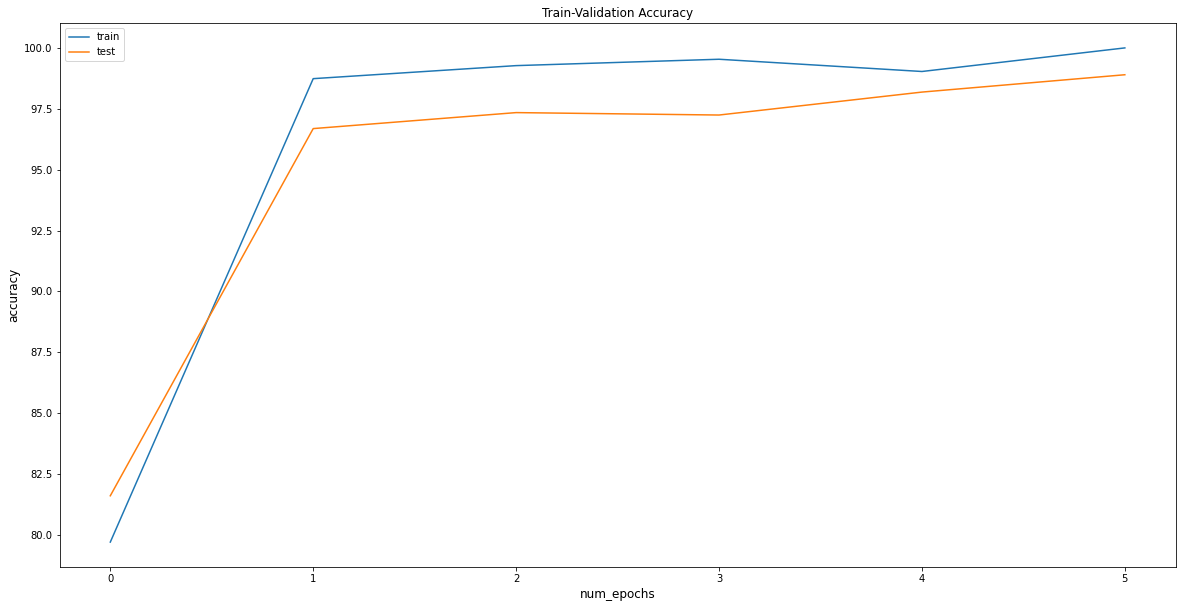

In [80]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_accuracy, label='train')
plt.plot(validation_accuracy, label='test')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

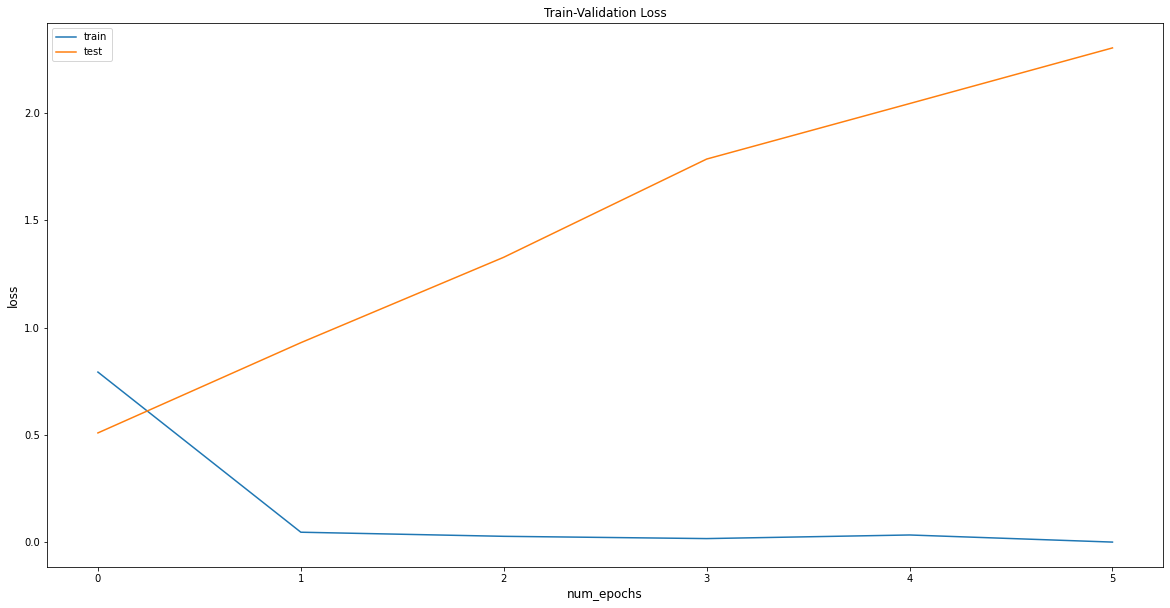

In [81]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='test')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

In [82]:
def pre_image(image,model):
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   transform_norm = transforms.Compose([transforms.ToTensor(), 
   transforms.Resize((100, 100)), transforms.Normalize(mean, std)])
   # get normalized image
   img_normalized = transform_norm(image).float()
   img_normalized = img_normalized.unsqueeze_(0)
   # input = Variable(image_tensor)
   img_normalized = img_normalized.to(device)
   # print(img_normalized.shape)
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      classes = test_set.classes
      class_name = classes[index]
      return class_name

In [86]:
#import cv2
from PIL import Image

model = CNN().to(device)
model.load_state_dict(torch.load('model_parameter.pkl'))
pil_image = Image.open('../peach_test1.webp')
pil_image.show()
predicted_class = pre_image(pil_image, model)
print('Predicted fruit or vegetables:', predicted_class)

Predicted fruit or vegetables: Peach


C:\Users\hejac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Referennce:
1. Fruits 360 on Kaggle: https://www.kaggle.com/datasets/moltean/fruits
2. PyTorch Training a classifier: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
3. Define a Neural Network in PyTorch: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html